# Определение перспективного тарифа для телеком компании

В нашем распоряжении данные 500 пользователей компании «Мегалайн» — федерального оператора сотовой связи, за 2018 год. Компания предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

*Цель исследования* - проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

План действий:
- Откроем и изучим файл с данными
- Предобработаем данные для улучшения качества проводимого анализа
- Ответим на главные вопросы исследования
- Сформулируем общий вывод

## Оглавление

1. [Откроем файл с данными и изучим общую информацию](#step1)
2. [Подготовка данных](#step2)
    * [Исправление ошибок в данных и приведение к нужным типам](#err) 
        * [Информация о звонках](#call)
        * [Информация об интернет-сессиях](#inet)
        * [Информация о сообщениях](#mesg)
        * [Информация о пользователях](#user)
        * [Информация о тарифах](#tarif)
    * [Категоризация и слияние данных](#cat)
        * [Количество сделанных звонков и израсходованных минут разговора по месяцам](#callcount)
        * [Количество отправленных сообщений по месяцам](#mesgcount)
        * [Объем израсходованного интернет-трафика по месяцам](#inetcount)
        * [Помесячная выручка с каждого пользователя](#proceed)
3. [Анализ данных](#step3)
    * [Минуты разговора](#min)
    * [Количество сообщений](#msssg)
    * [Объём интернет-трафика](#inetv)
4. [Проверка гипотез](#step4)
    * [Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается](#tarifdif)
    * [Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#mscdif)
5. [Общий вывод](#end)

<a id="step1"></a>
# Шаг 1. Откроем файлы с данными и изучим общую информацию

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица df_calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [2]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Таблица df_internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [3]:
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица df_messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [4]:
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица df_tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со - 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [5]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица df_users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

### Вывод:

Входные данные представляют собой 5 таблиц. Мы кратко ознакомились с информацией из всех таблиц, а так же узнали о хранящихся в них данных: их количество и типы.

Пропущенные значения встретились только в одной - df_users.

Также были экспортированы библиотеки, которые будут нужны для выполнения проекта.

<a id="step2"></a>
# Шаг 2. Подготовка данных

<a id="err"></a>
## Исправление ошибок в данных и приведение к нужным типам

<a id="call"></a>
### Информация о звонках

Начнем с таблицы **df_calls**. Еще раз взглянем на общую информацию.

In [6]:
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Проверим на наличие дубликатов.

In [7]:
df_calls.duplicated().sum()

0

Полных дубликатов нет.

В столбце *duration* значения представленны в вещественном типе данных. Из технической документации нам извечтно, что «Мегалайн» всегда округляет значения минут вверх, для подсчета оплаты. Соответственно и нам стоит поступить так же. Однако в данном столбце присутствуют нулевые значения. Это могут быть как пропущенные звонки, так и недозвоны. В подобных случаях оплата не взимается и для целей анализа такие данные не представляют интереса, поэтому удалим нули, а остальные данные округлим по правилам "Мегалайна" вверх.

Помимо столбца duration, есть еще один, требующий изменений. Данные в столбце *call_date* представленны в виде строк. Здесь предствлена информация о дате, поэтому и приведем столбец к соответтвующему типу данных.

Осуществим изменения и еще раз взглянем на таблицу.

In [8]:
# оставляем только ненулевые значения
df_calls = df_calls.query('duration != 0').reset_index(drop=True)

# округляем значения вврех
df_calls['duration'] = np.ceil(df_calls['duration'])

# изменяем формат записи времени
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls.head()

,id,call_date,duration,user_id
0,1000_2,2018-06-11,3.0,1000
1,1000_3,2018-09-21,14.0,1000
2,1000_4,2018-12-15,6.0,1000
3,1000_7,2018-08-22,19.0,1000
4,1000_8,2018-09-15,19.0,1000


<a id="inet"></a>
### Информация об интернет-сессиях

In [9]:
df_internet.duplicated().sum()

0

Дубликатов нет.

In [10]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Сразу видим, что таблица **df_internet** схожа с предыдущей по своим проблемам. Тут наверняка прсутствуют нулевые значения в объёме потраченного за сессию интернет-трафика, которые могут быть обусловлены потерей сети, слуйчайными включениями браузера или техническими сбоями - в любом случае, для анализа такие данные не представляют ценности. Удалим нули и по правилу «Мегалайна», который всегда округляет вверх значения мегабайтов приведем столбец *mb_used* к целочисленному типу данных. 

Данные столбца *session_date* приведем к типу данных daytime.

В таблице есть столбец *Unnamed: 0*, который не указан в технической документации. Значения в нем дублируют индексы и скорее всего он пояявился в результате технической ошибки, поэтому от него стоит избавиться.

Осуществим изменения и еще раз взглянем на таблицу.

In [11]:
#оставляем только ненулевые значения
df_internet = df_internet.query('mb_used != 0').reset_index(drop=True)

# округляем значения вврех
df_internet['mb_used'] = df_internet['mb_used'].apply(math.ceil)

# изменяем формат записи времени
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

#удаляем столбец Unnamed: 0
df_internet = df_internet.drop('Unnamed: 0', 1)
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


<a id="mesg"></a>
### Информация о сообщениях

In [12]:
df_messages.duplicated().sum()

0

Дубликатов нет.

In [13]:
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


В данной таблице изменений требует только формат записи даты, приведем столбец *message_date* к соответствующему типу.

In [14]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

<a id="user"></a>
### Информация о пользователях

In [15]:
df_users.duplicated().sum()

0

Дубликатов нет.

In [16]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Здесь сразу видим, что в столбце **churn_date** большая часть значений пропуски. Они означают, что тариф ещё действовал на момент выгрузки данных. Удалять или заменять их нет смысла, поэтому оставшиеся значения, так как они представляют информацию о дате - приведем к типу datetime, также к этому типу приведем и данные в столбце *reg_date*.

In [17]:
def todaytime_churn_date(ceil):
    '''
    функция принимает строку и преобразует ее в тип данных datetime, если значение не отсутствует
    '''
    if pd.notna(ceil):
        return pd.to_datetime(ceil, format='%Y-%m-%d')
    
# применим функцию к столбцу churn_date
df_users['churn_date'] = df_users['churn_date'].apply(todaytime_churn_date)
# приведем столбец reg_date к datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

Данные в остальных столбцах выглядят нормально, поэтому болше изменений делать не будем. Разве что стоит проверить: нет ли людей с аномальными значения в столбце *age*. Отфильтруем несовершеннолетних, ведь на них не может быть оформлен тариф, а так же людей возрастом более 100 лет.

In [18]:
len(df_users.query('age > 100 or age < 18'))

0

Таких значений нет.

<a id="tarif"></a>
### Информация о тарифах

In [19]:
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Еще на стадии изучения данных было ясно, что таблица df_tariffs не нуждается в изменениях. Она состоит всего из двух, каждая из которых описывает один из предложенных тарифов. Все данные соответствуют нужным типам.

### Вывод:
В целях улучшения анализа, была отброшена часть данных, которая была бесполезна для целей исследования. Все данные приведены к нужным типам и соответственно исключены возможные ошибки из-за конфликтов между типами данных.

<a id="cat"></a>
## Категоризация и слияние данных

В интересах последующего анализа, стоит добавить несколько новых столбцов, которые бы явно отражали интересующую нас информацию.

<a id="callcount"></a>
### Количество сделанных звонков и израсходованных минут разговора по месяцам

Создадим сводную таблицу из таблицы **df_calls**, в которой будут отражаться интересующие нас параметры и посмотрим на результат.

In [20]:
# сначала создадим новый столбец month, в который запишем месяц
df_calls['month'] = df_calls['call_date'].dt.month

# сохраним в переменной calls_pivot нашу сводную таблицу, в которой будут отображены оличество сделанных звонков
# и израсходованных минут разговора по месяцам
calls_pivot = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()

#переименуем столбцы для наглядности
calls_pivot.columns = ['user_id', 'month', 'calls_count', 'calls_minutes_spent']
calls_pivot.head()

,user_id,month,calls_count,calls_minutes_spent
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0


<a id="mesgcount"></a>
### Количество отправленных сообщений по месяцам

Осуществим то же самое с таблицей **df_messages**.

In [21]:
df_messages['month'] = df_messages['message_date'].dt.month

messages_pivot = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages_pivot.columns = ['user_id', 'month', 'messages_count']
messages_pivot.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


<a id="inetcount"></a>
### Объем израсходованного интернет-трафика по месяцам

Еще раз повторим алгоритм для таблицы **df_internet**.

In [22]:
df_internet['month'] = df_internet['session_date'].dt.month
internet_pivot = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()

internet_pivot.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


<a id="proceed"></a>
### Помесячная выручка с каждого пользователя

Для подсчета помесячной выручки для каждого пользователя будет неудобно вытаскивать разные столбцы из разных таблиц. Поэтому сначала объеденим таблицы *df_users* и *df_tariffs*, а затем добавим к ним новые: *calls_pivot, messages_pivot и internet_pivot*. Результат объединения запишем в переменную **data** и посмотрим на получившуюся таблицу.

In [23]:
#сделаем так, чтобы было видно все столбцы
pd.options.display.max_columns = None

# сначала объеденим сводные таблицы по минутам, смс и интернету
data = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
data = data.merge(internet_pivot, on=['user_id', 'month'], how='outer')

# теперь добавим информацию по пользователям и их тарифам
data = data.merge(df_users, on='user_id', how='outer')
data = data.merge(df_tariffs, left_on='tariff', right_on='tariff_name', how='outer')

# удалим лишний
data = data.drop('tariff_name', 1)

data.head()

,user_id,month,calls_count,calls_minutes_spent,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,17.0,159.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,28.0,172.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,41.0,340.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,42.0,408.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,46.0,466.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Стоит проверить получившуюся таблицу на наличие пропущенных значений.

In [24]:
data.isna().sum()

user_id                     0
month                       2
calls_count                48
calls_minutes_spent        48
messages_count            499
mb_used                    15
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Первым делом в глаза бросаются два пропуска в столбце *month*. Взгялнем на эти строки.

In [25]:
data[pd.isna(data['month'])]

,user_id,month,calls_count,calls_minutes_spent,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
985,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1
3215,1371,NaN,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3


Судя по времени подключения и отключения от тарифа, эти люди просто не успели воспользоваться пакетом услуг. Для целей анализа подобные строки не нужны. Поэтому спокойно удалим их.

In [26]:
data = data.query('user_id != 1128 and user_id != 1371')

В столбцах *calls_count*, *calls_minutes_spent*, *messages_count* и *mb_used* всплывшие пропущенные значения означают лишь одно - клиент на протяжении месяца не пользовался одной из услуг. Соответственно пропущенные значения мы можем заменить на нули. Затем проверим еще раз таблицу на наличие пропусков.

In [27]:
data['calls_count'] = data['calls_count'].fillna(0)
data['calls_minutes_spent'] = data['calls_minutes_spent'].fillna(0)
data['messages_count'] = data['messages_count'].fillna(0)
data['mb_used'] = data['mb_used'].fillna(0)

data.isna().sum()

user_id                     0
month                       0
calls_count                 0
calls_minutes_spent         0
messages_count              0
mb_used                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Пропуски в столбце *churn_date* заполнять не будем, этот столбец не играет роли в анализе.

Так из выведеной ранее таблицы было заметно, что из-за пропусков значения в соответствующих столбцах обратились в вещественный тип данных. Приведем их обратно к целочисленному и выведем таблицу на экран.

In [28]:
data['calls_count'] = data['calls_count'].astype('int')
data['calls_minutes_spent'] = data['calls_minutes_spent'].astype('int')
data['messages_count'] = data['messages_count'].astype('int')
data['mb_used'] = data['mb_used'].astype('int')
data['month'] = data['month'].astype('int')

data.head()

,user_id,month,calls_count,calls_minutes_spent,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17,159,22,2256,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28,172,60,23257,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41,340,75,14016,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42,408,81,14070,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46,466,57,14581,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Теперь с легкостью можем посчитать выручку с каждого пользователя. Для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана и, наконец, прибавим абонентскую плату, соответствующую тарифному плану. Результат запишем в новый столбец *proceeds*.

In [29]:
def find_proceeds(row):
    '''
    функция принимает строку и возвращает полученную выручку с каждого человека помесячно;
    для каждого параметра рассчитывается оплата по принципу:
    вычитаем из потраченного значения лимитное, и если остаток больше нуля, то умножаем на стоимость сверх тарифного пакета,
    если же остаток меньше нуля, то не добавляем к абонентской плате переплаты по конкретному парамеру;
    для параметра интернет рассчет идет в гигабайтах
    '''
    calls = row['calls_minutes_spent'] - row['minutes_included']
    if calls > 0:
        calls *= row['rub_per_minute']
    else:
        calls = 0
        
    internet = row['mb_used'] - row['mb_per_month_included']
    if internet > 0:
        internet = math.ceil(internet / 1024) * row['rub_per_gb']
    else:
        internet = 0
        
    messages = row['messages_count'] - row['messages_included']
    if messages > 0:
        messages *= row['rub_per_message']
    else:
        messages = 0
        
    return calls + internet + messages + row['rub_monthly_fee']
        
# применим функцию к таблице   
data['proceeds'] = data.apply(find_proceeds, axis = 1)
#выведем резульат на экран
data.head()

,user_id,month,calls_count,calls_minutes_spent,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceeds
0,1000,5,17,159,22,2256,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1000,6,28,172,60,23257,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,1000,7,41,340,75,14016,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,1000,8,42,408,81,14070,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,1000,9,46,466,57,14581,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950


### Вывод:

Мы категоризовали часть данных, это поможет лучше ответить на вопросы исследования. Преобразованные таблицы были объеденены в одну, чтобы упростить извлечение информации.

<a id="step3"></a>
# Шаг 3. Анализ данных

Проанализируем три ключевых параметра и узнаем сколько каждого требуется пользователям тарифов в месяц. Опишем поведение клиентов оператора, исходя из выборки.

<a id="min"></a>
## Минуты разговора
Построим гистограмму по суммарной длительности телефонных разговоров по месяцам для обоих тарифов. Посчитаем средние и стандартные отклонения, а так же линиями обозначим средние выборок.

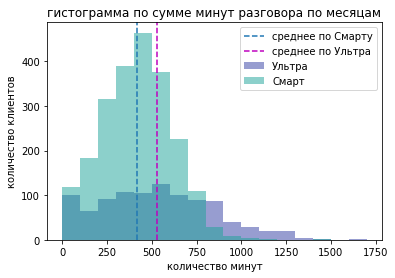

In [30]:
f = (data
     .query('tariff == "ultra"')
     .plot(kind='hist', y='calls_minutes_spent', alpha = 0.5, bins=[i for i in range(0, 1750, 100)], 
           color='#303da2', label='Ультра')
    )
(data
 .query('tariff == "smart"')
 .plot(kind='hist', y='calls_minutes_spent', ax=f, alpha = 0.5, bins=[i for i in range(0, 1750, 100)], 
       color='#1aa398', label='Смарт')
)

plt.axvline(x=417, linestyle='--', label='среднее по Смарту')
plt.axvline(x=527, linestyle='--', color='m', label='среднее по Ультра')

plt.title('гистограмма по сумме минут разговора по месяцам')
plt.xlabel('количество минут')
plt.ylabel('количество клиентов')
plt.legend()
plt.show()

In [31]:
def show_stat(df, ser):
    '''
    функция принимает датафрэйм и название столбца, возвращает среднее, дисперсию и стандартное отклонение
    для каждого тарифа
    '''
    smrt = df.query('tariff == "smart"')
    ultr = df.query('tariff == "ultra"')
    print('Смарт')
    print('Среднее: {:.2f}'.format( smrt[ser].mean() ))
    print('Дисперсия: {:.2f}'.format( np.var(smrt[ser], ddof=1) ))
    print('Стандартное отклонение: {:.2f}'.format( np.std(smrt[ser])), end ='\n\n')

    print('Ультра')
    print('Среднее: {:.2f}'.format( ultr[ser].mean() ))
    print('Дисперсия: {:.2f}'.format( np.var(ultr[ser], ddof=1) ))
    print('Стандартное отклонение: {:.2f}'.format( np.std(ultr[ser])), end ='\n\n')

show_stat(data, 'calls_minutes_spent')

Смарт
Среднее: 417.93
Дисперсия: 36219.32
Стандартное отклонение: 190.27

Ультра
Среднее: 526.62
Дисперсия: 100873.63
Стандартное отклонение: 317.44



В отличие от "Ультра", тарифный план "Смарт" имеет распределенеие близкое к нормальному.

Среднее по "Смарту" равно 420 минутам, это означает, что среднестатистическому пользователю этого тарифа вполне хватает лимита по минутам связи. Посчитаем какому проценту клиентов обычно не хватает лимита.

In [32]:
len(data.query('tariff == "smart" and calls_minutes_spent > 500')) / len(data)

0.23459863098942127

Около 23% клиентов пользуются услугами сверх тарифного пакета "Смарт".

Что касается пользователей "Ультра", то они всегда укладываются в лимит, а большая часть тратит не больше трети от предоставленных минут. В диапазоне от 200 до 900 минут распределение близкое к равномерному, на что нам и намекает высокое стандартное отклонение. До 200 количество людей немного меньше. После 800 минут идет резкий спад, и уже находятся лишь единицы клиентов, кто раговаривает по телефону более 1000 минут в месяц.

<a id="msssg"></a>
## Количество сообщений

Теперь взглянем на гистограмму по количеству сообщений по месяцам, а так же средние(на графике обозначим их линиями) и стандартные отклонения для обоих тарифов.

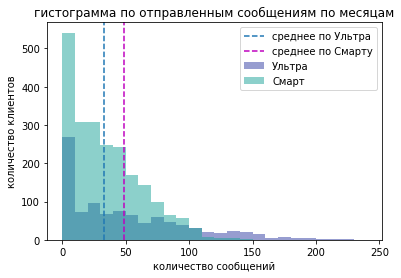

In [33]:
f = (data
     .query('tariff == "ultra"')
     .plot(y='messages_count', kind='hist', alpha = 0.5, bins=[i for i in range(0, 250, 10)], color='#303da2', label='Ультра'))
(data
 .query('tariff == "smart"')
 .plot(y='messages_count',kind='hist', ax=f, alpha = 0.5, bins=[i for i in range(0, 250, 10)], color='#1aa398', label='Смарт', legend=True))

plt.axvline(x=33, linestyle='--')
plt.axvline(x=49, linestyle='--', color='m')
plt.legend(("среднее по Ультра", "среднее по Смарту", 'Ультра', "Смарт"))
plt.title('гистограмма по отправленным сообщениям по месяцам')
plt.xlabel('количество сообщений')
plt.ylabel('количество клиентов')
plt.show()

In [34]:
show_stat(data, 'messages_count')

Смарт
Среднее: 33.38
Дисперсия: 796.81
Стандартное отклонение: 28.22

Ультра
Среднее: 49.36
Дисперсия: 2285.27
Стандартное отклонение: 47.78



Оба тарифа имеют большой пик в нуле. Это говорит о том, что сейчас мало ктопользуется сообщениями.

Не считая пика в нуле, распределение тарифа "Смарт" похоже на Пуассоновское. В среднем пользователи этого тарифа отправляют около 33 смс. Станжартное отклонение в 28, говорит что некоторым все же не хватает лимита.

In [35]:
len(data.query('tariff == "smart" and messages_count > 50')) / len(data)

0.17548226509023024

17% пользователей "Смарта" используют услуги сверх тарифного пакета.

Пользователи "Ультра" и тут еле смогли приблизиться к четветри лимита. В целом можно сказать, что они отправляют сообщения приблизительно как и пользователи "Смарта": у обоих большая часть значений лежит в пределе 60 смс. Однако если у "Смарта" идет резкий спад после 50 смс, на что скорее всего влияет лимит, то пользователи "Ультра", хоть и в ментьшем количестве, но активно отправляют до 100 смс в месяц.

<a id="inetv"></a>
## Объём интернет-трафика

Теперь исследуем объем израсходованного трафика по месяцам.

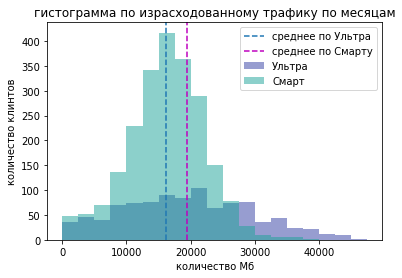

In [36]:
f = (data
     .query('tariff == "ultra"')
     .plot(kind='hist', y='mb_used', alpha = 0.5, color='#303da2', bins=[i for i in range(0, 50000, 2500)], label='Ультра'))
(data
 .query('tariff == "smart"')
 .plot(kind='hist', y='mb_used', ax=f, alpha = 0.5, color='#1aa398', bins=[i for i in range(0, 50000, 2500)], label='Смарт', legend=True))

plt.axvline(x=16229, linestyle='--')
plt.axvline(x=19488, linestyle='--', color='m')
plt.legend(("среднее по Ультра", "среднее по Смарту", 'Ультра', "Смарт"))
plt.title('гистограмма по израсходованному трафику по месяцам')
plt.xlabel('количество Мб')
plt.ylabel('количество клинтов')
plt.show()

In [37]:
show_stat(data, 'mb_used')

Смарт
Среднее: 16229.19
Дисперсия: 34545911.13
Стандартное отклонение: 5876.26

Ультра
Среднее: 19486.90
Дисперсия: 101935621.05
Стандартное отклонение: 10091.19



И снова распределение пользователей "Смарта" близко к нормальному. Среднее превышает лимит в 15 Гб, а это означает что многие пользуется услугами сверх пакета.

In [38]:
len(data.query('tariff == "smart" and mb_used > (15 * 1024)')) / len(data)

0.4072806471686372

Таких оказалось 40%. Пользователям "Смарта" явно сильно не хватает лимита по объёму интернет-трафика. 

Клиенты с тарифом "Ультра" же только здесь смогли превысить лимит пакета, однако таких единицы. Основная часть значений сосредоточена в диапазоне от 8 до 27 тысяч Мб, распределены они почти равномерно.

### Вывод:

Пользователи тарифа "Смарт" очень часто выходят за рамки своего пакета и вынуждены докупать услуги сверх тарифного пакета. Однако пики распределений были близки, а где то почти совпадали, со среднеми значениями, что говорит о том, что среднестатистическому пользователю хватает лимитов впритык. 

Пользователям "Ультра" наоборот предоставленого пакета слишком много, по крайней мере на звонки и сообщения точно. В пределах пользования распределения людей было преимущественно равномерным, что говорит о довольно разных способах пользования тарифом - тяжело выявить тенденцию.

Средний пользователь "Ультра" расходует каждой услуги по тарифу больше чем это делает средний пользователь "Смарта".

<a id="step4"></a>
# Шаг 4. Проверка гипотез

<a id="tarifdif"></a>
## Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Для проверки соотношения средних значений выборок отлично подходит критерий Стьюдента. Им и воспользуемся.

Для начала сформулируем нулевую гипотезу *Н0*, она должна содержать в себе равенство значений. Затем определим альтернативную гипотезу *Н1* как различие.
- **H0** - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова;
- **Н1** - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Решить отвергать или нет *Н0* нам поможет *p-value*. Оно покажет нам вероятность отвергнуть гипотезу *Н0*, при условии что она верна. Затем сравним *p-value* с общепринятым порогом статистической значимости в 5%.

Также для более точной проверки стоит понять сильно ли различаются дисперсии.

In [39]:
# разделим выборку по тарифу
smart = data.query('tariff == "smart"')['proceeds']
ultra = data.query('tariff == "ultra"')['proceeds']

print(f'Дисперсия "Смарт": {np.var(smart)}')
print(f'Дисперсия "Ультра": {np.var(ultra)}')

Дисперсия "Смарт": 673628.974426787
Дисперсия "Ультра": 143345.5641732588


Они довольно сильно отличаются, поэтому укажем это при сравнении.

In [40]:
# с помощью метода ttest_ind() сравним средние выборок
# параметр equal_var установим как False, так как дисперсии сильно отличаются
results = st.ttest_ind(smart, ultra, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else: 
    print('Нет оснований отвергать нулевую гипотезу')

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


Тест показал, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается на уровне значимости в 5%. 

Мы не можем оценить по выборке насколько точно в действительности различается средняя выручка, однако раз тест Стюдента показал, что средние различны, то мы можем по средним наших выборок сказать у какого тарифа большая средняя выручка.

In [41]:
print(f'Среднее "Смарт": {smart.mean()}')
print(f'Среднее "Ультра": {ultra.mean()}')

Среднее "Смарт": 1294.6393001345896
Среднее "Ультра": 2071.0659898477156


### Вывод:
Предположение подтвердилось - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. В среднем пользователь тарифа "Ультра" приносит больше денег компании.

### Дополнение

Средняя выручка тарифа "Ультра" больше, но такой факт не даст нам полного представления о том какой тариф прносит больше денег. Посчитаем долю выручки для каждого тарифа. 

Доля выручки "Смарт": 59%
Доля выручки "Ультра": 41%


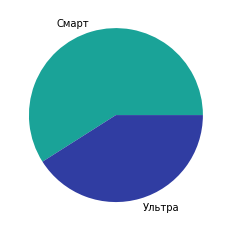

In [42]:
print(f'Доля выручки "Смарт": {round((smart.sum() / (smart.sum() + ultra.sum())) * 100)}%')
print(f'Доля выручки "Ультра": {round((ultra.sum() / (smart.sum() + ultra.sum())) * 100)}%')

tarrif = ['Смарт', 'Ультра']
values = [59, 41]
plt.pie(values, labels=tarrif, colors=['#1aa398', '#303da2'])
plt.show()

### Дополнительный вывод:

Конкретный средний пользователь "Ультра" приносит больше, нежели "Смарта", но большую часть общей выручки приносит как раз "Смарт".

<a id="mscdif"></a>
## Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Для проверки этого предположения тоже воспользуемся критерием стюдента. Здесь:
- **H0** - средняя выручка пользователей из Москвы и выручка пользователей из других регионов одинакова;
- **H1** - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для начала сравним дисперсии.

In [43]:
# разделим выборку по геопозиции
moscow = data.query('city == "Москва"')['proceeds']
provinces = data.query('city != "Москва"')['proceeds']

print(f'Дисперсия по Москве: {np.var(moscow)}')
print(f'Дисперсия по остальным городам": {np.var(provinces)}')

Дисперсия по Москве: 565256.3794161058
Дисперсия по остальным городам": 656514.2841040562


Дисперсии отличаются более чем на 5%, следовательно будем считать их различными.

Теперь проведем тест Стьюдента.

In [44]:
moscow = data.query('city == "Москва"')['proceeds']
provinces = data.query('city != "Москва"')['proceeds']

results2 = st.ttest_ind(moscow, provinces, equal_var = False)

print('p-значение:', results2.pvalue)

if results2.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else: 
    print('Нет оснований отвергать нулевую гипотезу')

p-значение: 0.5126564657748214
Нет оснований отвергать нулевую гипотезу


### Вывод: 
Результат показал, что средняя выручка пользователей из Москвы и выручка пользователей из других регионов одинакова на уровне 5% значимости.

<a id="end"></a>
# Шаг 5. Общий вывод

Входные данные состояли из 5 таблиц, содержащих инофрмацию о 500 клиентах компании "Мегалайн" и их пользование услугами, входящими в тарифный план.

Во время предобработки были выявлены следующие *проблемы*: 
- отстутсвующие значения
- несоответствие даных ожидаемому типу
- нулевые значения в местах, где их быть не должно

Каждая из проблем была обработана соответствующими методами и исправлена по принципу улучшения качества последеющего анализа.

Таблицы были агрегированны и объеденны в одну, которая давала исчерпывающие ответы на вопросы исследования.

**Результаты анализа установили:**
- В среднем пользователь тарифа "Ультра" приносит *больше* денег компании, нежели пользователь "Смарта" на 20%.
- Пользователи "Смарта" часто выходят за рамки предоставленного лимита. Докупают дополнительные минуты и сообщения около 20% пользователей, а для интернета этот показатель равен 40%.
- Пользователям "Ультра" наоборот пакета слишком много, почти все клиенты не успевают израсходовать лимиты.
- Большую часть выручки делает "Смарт" - *59%* от общей выручки.
- Компании не стоит различать Москву от остальных городов.

Компании "Мегалайн" *рекомендуется* направить большую часть рекламного бюджета на развитие тарифа "Ультра", но и оставить достаточное количество средств на поддержку "Смарта", так как он является основным источником дохода.

Компании "Мегалайн" *рекомендуется* провести дополнительное исследование, которое покажет насколько сильно окупается каждый тариф.

Компании "Мегалайн" *рекомендуется* придумать новый тариф с лимитами: 750 минут разговора, 75 сообщений и 23 Гб интернет-трафика. Такой тариф будет удовлетрять большую часть клиентов.
